# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# План работы:

1) Подготовить данные:

- Проверить эффективность обогащения и вычислить её на обучающей выборке для признака rougher.output.recovery. Найти MAE между расчётами и значением признака.

- Проанализировать признаки, недоступные в тестовой выборке.

- Провести предобработку данных.

2) Проанализировать данные:

- Проанализировать как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

- Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках.

- Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Описать выводы и удалить аномалии.

3) Построить модель:

- Написать функцию для вычисления итоговой sMAPE.

- Обучить разные модели и оценить их качество. Выбрать лучшую модель и проверить её на тестовой выборке.

4) Общий вывод


# Описание данных
    
Наименование признаков: 
- [этап].[тип_параметра].[название_параметра]

**Пример:** rougher.input.feed_ag

**Возможные значения для блока [этап]:**

- rougher — флотация

- primary_cleaner — первичная очистка

- secondary_cleaner — вторичная очистка

- final — финальные характеристики

**Возможные значения для блока [тип_параметра]:**

- input — параметры сырья

- output — параметры продукта

- state — параметры, характеризующие текущее состояние этапа

- calculation — расчётные характеристики

**Параметры этапов:**

- air amount — объём воздуха

- fluid levels — уровень жидкости

- feed size — размер гранул сырья

- feed rate — скорость подачи

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import scipy
import statistics
from scipy import stats as st

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.dummy import DummyRegressor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Напишем функцию для открытия файла и вызова необходимых сведений о датасетах, а затем ознакомимся с ними:

In [2]:
def data_read_exam(file_path):
    # читаем данные из .csv файла с помощью метода read_csv()
    data = pd.read_csv(file_path, index_col = 'date')
    display(data.head(10))
    print(data.info())
    print('Количество дубликатов:', sum(data.duplicated()))
    return data

In [3]:
full_df = data_read_exam('/datasets/gold_recovery_full_new.csv')

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,115.581252,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,117.322323,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,124.592960,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,131.781026,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188


<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

In [4]:
train_df = data_read_exam('/datasets/gold_recovery_train_new.csv')

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,115.581252,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,117.322323,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,124.592960,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,131.781026,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188


<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

In [5]:
test_df = data_read_exam('/datasets/gold_recovery_test_new.csv')

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,-497.903666,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,-497.923683,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,-503.451306,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,-499.890350,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716


<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

In [6]:
print('Колличество пропусков в тестовой выборке:', test_df.isnull().sum().sum())
print('Колличество пропусков в обучающей выборке:', train_df.isnull().sum().sum())
print('Колличество пропусков в полной выборке:', full_df.isnull().sum().sum())

Колличество пропусков в тестовой выборке: 90
Колличество пропусков в обучающей выборке: 4100
Колличество пропусков в полной выборке: 4481


**Вывод после ознакомления:**

- Данные соответствуют описанию. Дубликатов нет. Датасеты состаят из более чем десятка тысяч записей, full 86 признаков, test 52, train тоже 86. То, что у нас в тестовой выборке почти в два раза меньше признаков заставляет задуматься о том, как мы будем обучать модель.

- Наличествуют пропуски (всего 90 в тестовой выборке и более 4 тысяч в трейн выборке). Причина неизвестна.

- Типы данных соответствуют описанию.

- Масштаб признаков сильно отличается (порой разница в два порядка). Признаки нуждаются в масштабировании.

### Расчёт эффективности обогащения

Проверим правильно ли рассчитана эффективность обогащения в нашей обучающей выборке, которая лежит в столбце rougher.output.recovery. Для этого вручную расчитаем нашу эффективность по формуле:

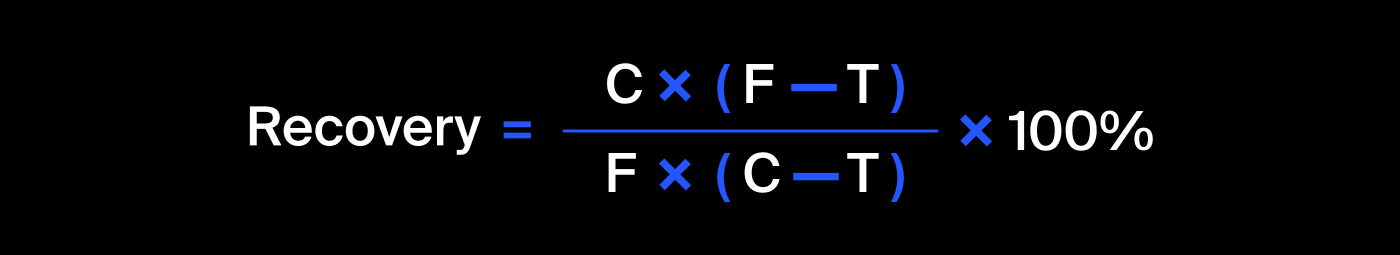

Где:

- C — доля золота в концентрате после флотации/очистки

- F — доля золота в сырье/концентрате до флотации/очистки

- T — доля золота в отвальных хвостах после флотации/очистки

И найдём cреднюю абсолютную ошибку между нашими расчётами и значением признака в столбце. 

In [7]:
C = train_df['rougher.output.concentrate_au']
F = train_df['rougher.input.feed_au']
T = train_df['rougher.output.tail_au']

In [8]:
recovery = C * (F - T) / (F * (C - T)) * 100

Рассчитать лучше через эту формулу, так как из-за пропусков формула из библиотеки может не справиться.

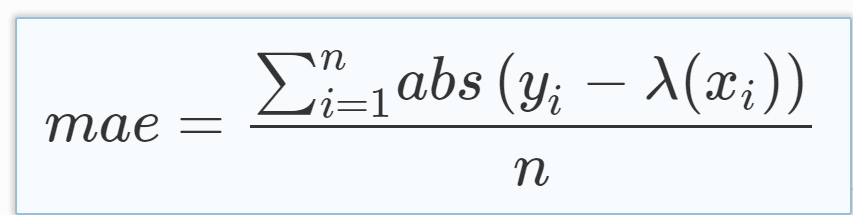

In [9]:
(abs(recovery - train_df['rougher.output.recovery']).sum()) / len(train_df)

9.73512347450521e-15

**Вывод:** Разница исчезающе мала 9.73512347450521e-15, а это значит - процесс идет в штатном режиме.

### Анализ признаков, недоступных в тестовой выборке

Как было отмечено раньше, тестовая выборка содержит значительно меньше признаков, чем обучающая:

In [10]:
train_df.shape[1] - test_df.shape[1]

34

Изучим, какие признаки у нас отсутствуют в тестовой выборке:

In [11]:
train_df.columns.drop(test_df.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

**Вывод:**

Видим, что в тестовой выборке у нас отсутствуют все этапы на которых были получены параметры продукта из сырья. Условно, конечные значения после каждого этапа обработки. Это говорит нам о том, что мы должны удалить из train все, чего нету в test, иначе модель будет давать неадекватные результаты.

### Предобработка данных

Для начала удалим строки с пропусками в целевом признаке, а позже и сами ненужные нам столбцы.

In [12]:
train_df.dropna(subset=['final.output.recovery', 'rougher.output.recovery'], inplace=True)

In [13]:
drop_test = train_df.columns.drop(test_df.columns)

In [14]:
train_df.drop(drop_test, axis=1, inplace=True)

Заполним пропуски с помощью метода K-ближайших соседей:

In [15]:
def transform_imputer(data, n_neighbors):

    data_columns = data.columns
    index = data.index
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputer.fit_transform(data)
    

    return pd.DataFrame(imputer.fit_transform(data), columns=data_columns, index=index)

In [16]:
new_train_df = transform_imputer(train_df, 5)
new_test_df = transform_imputer(test_df, 5)

In [17]:
print('Количество пропусков до обработки данных в обучающей выборке:', train_df.isnull().sum().sum())
print('Количество пропусков после обработки данных в обучающей выборке:', new_train_df.isnull().sum().sum())
print('Количество пропусков до обработки данных в тестовой выборке:', test_df.isnull().sum().sum())
print('Количество пропусков после обработки данных в тестовой выборке:', new_test_df.isnull().sum().sum())

Количество пропусков до обработки данных в обучающей выборке: 1705
Количество пропусков после обработки данных в обучающей выборке: 0
Количество пропусков до обработки данных в тестовой выборке: 90
Количество пропусков после обработки данных в тестовой выборке: 0


Итак, мы заполнили пропуски, и теперь можем анализировать данные, а потом и обучать модели.

## Анализ данных

### Анализ концентрации металлов на различных этапах очистки

Найдем все столбцы относящиеся к конкретному металлу(Au, Ag, Pb), и будем использовать их для дальнейшего анализа:

In [18]:
full_df.columns[full_df.columns.str.endswith('au')], full_df.columns[full_df.columns.str.endswith('ag')],\
full_df.columns[full_df.columns.str.endswith('pb')]

(Index(['final.output.concentrate_au', 'final.output.tail_au',
        'primary_cleaner.output.concentrate_au',
        'primary_cleaner.output.tail_au', 'rougher.input.feed_au',
        'rougher.output.concentrate_au', 'rougher.output.tail_au',
        'secondary_cleaner.output.tail_au'],
       dtype='object'),
 Index(['final.output.concentrate_ag', 'final.output.tail_ag',
        'primary_cleaner.output.concentrate_ag',
        'primary_cleaner.output.tail_ag', 'rougher.input.feed_ag',
        'rougher.output.concentrate_ag', 'rougher.output.tail_ag',
        'secondary_cleaner.output.tail_ag'],
       dtype='object'),
 Index(['final.output.concentrate_pb', 'final.output.tail_pb',
        'primary_cleaner.output.concentrate_pb',
        'primary_cleaner.output.tail_pb', 'rougher.input.feed_pb',
        'rougher.output.concentrate_pb', 'rougher.output.tail_pb',
        'secondary_cleaner.output.tail_pb'],
       dtype='object'))

Теперь так куда проще искать. Отберём нужные нам столбцы, а именно:

- сырьё в исходном виде

- после флотации

- после первичной обработки

- финальный концентрат.

In [19]:
AU = full_df[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 
            'final.output.concentrate_au']].dropna()
AG = full_df[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 
            'final.output.concentrate_ag']].dropna()
PB = full_df[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 
            'final.output.concentrate_pb']].dropna()

In [20]:
print('Концентрация до флотации:')
print('серебро:{: 0.2f}, свинец:{: 0.2f}, золото:{: 0.2f}'.format(AG['rougher.input.feed_ag'].median(),
PB['rougher.input.feed_pb'].median(),
AU['rougher.input.feed_au'].median()))
print()
print('Концентрация после флотации:')
print('серебро:{: 0.2f}, свинец:{: 0.2f}, золото:{: 0.2f}'.format(AG['rougher.output.concentrate_ag'].median(),
PB['rougher.output.concentrate_pb'].median(),
AU['rougher.output.concentrate_au'].median()))
print()
print('Концентрация после первичной очистки:')
print('серебро:{: 0.2f}, свинец:{: 0.2f}, золото:{: 0.2f}'.format(AG['primary_cleaner.output.concentrate_ag'].median(),
PB['primary_cleaner.output.concentrate_pb'].median(),
AU['primary_cleaner.output.concentrate_au'].median()))
print()
print('Финальный концентрат:')
print('серебро:{: 0.2f}, свинец:{: 0.2f}, золото:{: 0.2f}'.format(AG['final.output.concentrate_ag'].median(),
PB['final.output.concentrate_pb'].median(),
AU['final.output.concentrate_au'].median()))

Концентрация до флотации:
серебро: 8.59, свинец: 3.54, золото: 8.13

Концентрация после флотации:
серебро: 12.10, свинец: 7.75, золото: 20.28

Концентрация после первичной очистки:
серебро: 8.51, свинец: 10.16, золото: 32.84

Финальный концентрат:
серебро: 5.07, свинец: 10.12, золото: 45.01


Концентрации металлов посчитаны, остается отобразить их на графике:

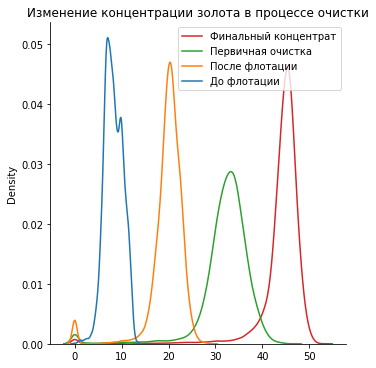

In [21]:
sns.displot(AU, legend=False, kind='kde')
plt.legend(['Финальный концентрат', 'Первичная очистка', 'После флотации', 'До флотации'], fontsize=10)
plt.title('Изменение концентрации золота в процессе очистки');

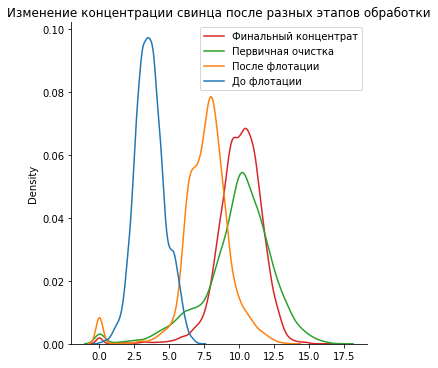

In [22]:
sns.displot(PB, legend=False, kind='kde')
plt.legend(['Финальный концентрат', 'Первичная очистка', 'После флотации', 'До флотации'], fontsize=10)
plt.title('Изменение концентрации свинца после разных этапов обработки');

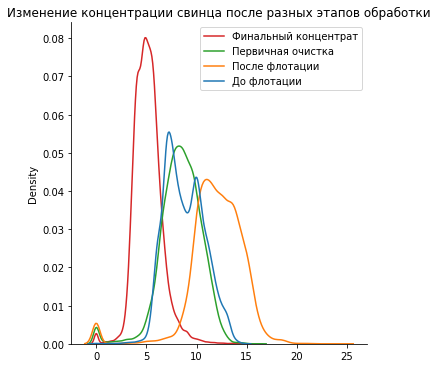

In [23]:
sns.displot(AG, legend=False, kind='kde')
plt.legend(['Финальный концентрат', 'Первичная очистка', 'После флотации', 'До флотации'], fontsize=10)
plt.title('Изменение концентрации свинца после разных этапов обработки');

**Вывод:** Итак, можно наблюдать что с каждым этапом очистки концентрация золота заметно увеличивается (что логично, мы же получаем золото из руды), в то время как концентрация серебра наоборот снижается. Свинец показывает небольшое увелечение концентрации, а затем она остается примерно на одном уровне.

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

Возьмем для анализа столбец feed_size:

In [24]:
new_train_df_feed_size = new_train_df['rougher.input.feed_size'].groupby(new_train_df.index).agg('mean')
new_test_df_feed_size = new_test_df['rougher.input.feed_size'].groupby(new_test_df['rougher.input.feed_size'].index).agg('mean')

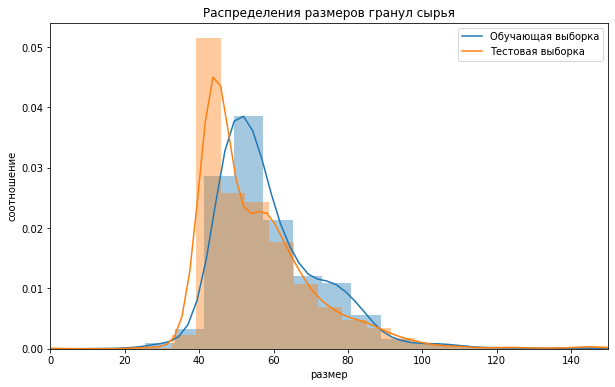

In [25]:
f, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.distplot(new_train_df_feed_size, bins=60)
sns.distplot(new_test_df_feed_size, bins=60);
plt.legend(['Обучающая выборка', 'Тестовая выборка'])
plt.title('Распределения размеров гранул сырья')
plt.xlabel('размер')
plt.ylabel('соотношение');
axes.set_xlim(0, 150);

**Вывод:** В целом и у тренинг и у тест выборки распределение по размером гранул имеет схожий вид, и значения близки. Мы можем использовать этот признак для обучения модели.

### Cуммарная концентрация всех веществ на разных стадиях

Посчитаем суммарные концентрации веществ для трех стадий: в сырье, в черновом и финальном концентратах.

In [26]:
feed_concentrate = full_df['rougher.input.feed_ag'] + full_df['rougher.input.feed_pb'] +\
            full_df['rougher.input.feed_sol'] + full_df['rougher.input.feed_au']
rougher_concentrate = full_df['rougher.output.concentrate_ag'] + full_df['rougher.output.concentrate_pb'] +\
            full_df['rougher.output.concentrate_sol'] + full_df['rougher.output.concentrate_au']
final_concentrate = full_df['final.output.concentrate_ag'] + full_df['final.output.concentrate_pb'] +\
            full_df['final.output.concentrate_sol'] + full_df['final.output.concentrate_au']

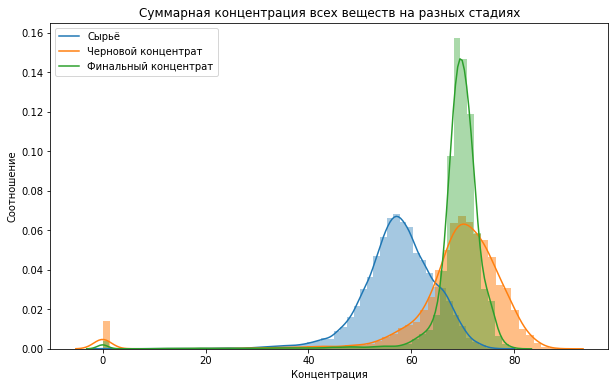

In [27]:
f, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.distplot(feed_concentrate, bins=60)
sns.distplot(rougher_concentrate, bins=60, hist_kws=dict(alpha=0.5));
sns.distplot(final_concentrate, bins=60);
plt.legend(['Сырьё', 'Черновой концентрат', 'Финальный концентрат'])
plt.title('Суммарная концентрация всех веществ на разных стадиях')
plt.xlabel('Концентрация')
plt.ylabel('Соотношение');

**Вывод:** 

Видим, что в районе нуля находятся каки-то непонятные выбросы. Мы можем их удалить. 

Для построения более точной модели можно вообще отсечь значения до 25-30, только оттуда появляется значимое число данных. Но для сырья оставим все как есть, т.к. мы не знаем в каком виде оно поступает на производство (может это особенность месторождения или что-то другое).

In [28]:
full_df = full_df.query('@feed_concentrate > 1 & @rougher_concentrate > 25 & @final_concentrate > 25')

Теперь подготовим наши выборки для обучения. Для этого добавим целевые признаки по индексам. Чтобы индексы в обеих выборках совпадали. Так мы отберём из трейна выбросы, которые мы обнаружили в полной выборке. Тоже самое действие проделаем и с тестовой выборкой.

In [29]:
good_df_for_train = pd.merge(new_train_df, full_df[['rougher.output.recovery', 'final.output.recovery']],
        left_index=True, right_index=True)

Посмотрим, что получилось:

In [30]:
print('Количество строк до объединения в обучающей выборке', new_train_df.shape[0])
print('Количество строк после объединения в обучающей выборке', good_df_for_train.shape[0])

Количество строк до объединения в обучающей выборке 14149
Количество строк после объединения в обучающей выборке 13348


Аналогичные действия для тестовой выборки:

In [31]:
good_df_for_test = pd.merge(new_test_df, full_df[['rougher.output.recovery', 'final.output.recovery']],
         left_index=True, right_index=True)

In [32]:
print('Количество строк до объединения в тестовой выборке', new_test_df.shape[0])
print('Количество строк после объединения в тестовой выборке', good_df_for_test.shape[0])

Количество строк до объединения в тестовой выборке 5290
Количество строк после объединения в тестовой выборке 5122


In [33]:
good_df_for_train.isnull().sum().sum()

0

Пропусков нет, и это хорошо.

## Модель

Разделим наши выборки на признаки для обучения и целевые признаки:

In [34]:
x_train = good_df_for_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_train_rougher = good_df_for_train['rougher.output.recovery']
y_train_final = good_df_for_train['final.output.recovery']
x_test = good_df_for_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_test_rougher = good_df_for_test['rougher.output.recovery']
y_test_final = good_df_for_test['final.output.recovery']

Формула для sMAPE, нашей целевой метрики имеет следующий вид:

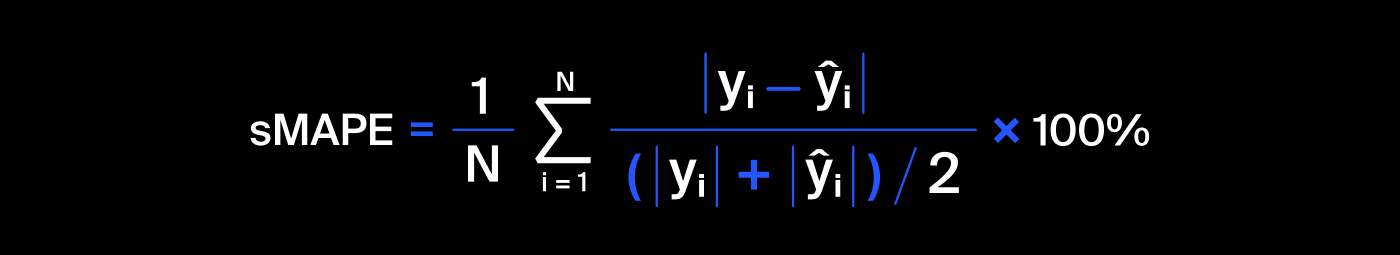

In [35]:
def sMAPE(true, pred):
    return 100/len(true) * np.sum(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred)))

Итоговый sMAPE рассчитывается по формуле:

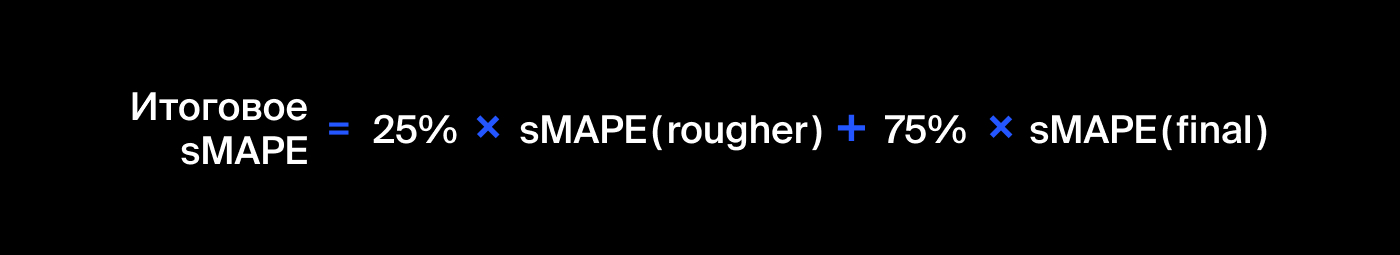

In [36]:
def the_total_sMAPE(sMAPE_rougher,sMAPE_final):
    return (0.25 * sMAPE_rougher + 0.75 * sMAPE_final)

Создадим скорер для наших моделей:

In [37]:
smape_score = make_scorer(sMAPE, greater_is_better=False)

Соберем в пайплайн шаги, которые могут быть проверены вместе при установке разных параметров, а именно масштабирование данных и обучение модели:

Будем обучать три модели: ЛАССО, Форестрегрессор и дерево-регрессор:

In [38]:
lasso_model = make_pipeline(StandardScaler(), Lasso(random_state=123))
forestregressor_model = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123))
treeregressor_model = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=123))

**Вывод:** Все готово к обучению, осталось передать параметры для кросс-валидации и начать процесс.

In [39]:
forestregressor_params = {'randomforestregressor__n_estimators':range(10, 41, 10),
             'randomforestregressor__max_depth':range (1,5)}
treeregressor_params= {'decisiontreeregressor__max_depth':range (1,20)}
lasso_params = {'lasso__alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}

*Комментарий:* Для модели машинного обучения важна не только точность, но и скорость работы, поэтому будем ориентироваться исходя из расчета 3-4 минуты на обучение одной модели, не больше.

In [40]:
grid_rougher_lasso = RandomizedSearchCV(lasso_model, param_distributions = lasso_params, cv=10,
                                            scoring = smape_score, n_jobs=-1)
grid_final_lasso = RandomizedSearchCV(lasso_model, param_distributions = lasso_params, cv=10,
                                            scoring = smape_score, n_jobs=-1)

*Комментарий:* Лассо работает быстро, можно поставить побольше кросс-валидаций.

In [41]:
grid_rougher_forestregressor = RandomizedSearchCV(forestregressor_model, cv=3, param_distributions = forestregressor_params,
                                            scoring = smape_score, n_jobs=-1)
grid_final_forestregressor = RandomizedSearchCV(forestregressor_model, cv=3, param_distributions = forestregressor_params,
                                          scoring=smape_score, n_jobs=-1)

*Комментарий:* Лес большой, в нем легко заблудиться - процесс идет медленно, надо либо сужать диапазон исследуемых параметров, либо уменьшить количество кросс-валидаций.

In [42]:
grid_rougher_treeregressor = RandomizedSearchCV(treeregressor_model, cv=10, param_distributions = treeregressor_params, 
                                          scoring=smape_score, n_jobs=-1)
grid_final_treeregressor = RandomizedSearchCV(treeregressor_model, cv=10, param_distributions = treeregressor_params, 
                                        scoring=smape_score, n_jobs=-1)

*Комментарий:* В одной сосне не потеряешься, хотя некоторым под силу и это.

Переходим к обучению наших моделей:

In [43]:
%%time
grid_rougher_lasso.fit(x_train,y_train_rougher)
grid_final_lasso.fit(x_train,y_train_final)

CPU times: user 57.5 s, sys: 2min 10s, total: 3min 8s
Wall time: 3min 8s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('lasso',
                                              Lasso(random_state=123))]),
                   n_jobs=-1,
                   param_distributions={'lasso__alpha': [0.02, 0.024, 0.025,
                                                         0.026, 0.03]},
                   scoring=make_scorer(sMAPE, greater_is_better=False))

Смотрим показатели метрик:

In [44]:
grid_rougher_lasso.best_score_

-5.817354892513924

In [45]:
grid_final_lasso.best_score_

-9.095678782737593

Обучаем лес:

In [46]:
%%time
grid_rougher_forestregressor.fit(x_train,y_train_rougher)
grid_final_forestregressor.fit(x_train,y_train_final)

CPU times: user 1min 53s, sys: 2.93 s, total: 1min 56s
Wall time: 1min 56s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=123))]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': range(1, 5),
                                        'randomforestregressor__n_estimators': range(10, 41, 10)},
                   scoring=make_scorer(sMAPE, greater_is_better=False))

Взглянем на метрики:

In [47]:
grid_rougher_forestregressor.best_score_

-7.832232149397167

In [48]:
grid_final_forestregressor.best_score_

-9.246847831553712

А теперь дерево:

In [49]:
%%time
grid_rougher_treeregressor.fit(x_train,y_train_rougher)
grid_final_treeregressor.fit(x_train,y_train_final)

CPU times: user 1min 31s, sys: 1.37 s, total: 1min 32s
Wall time: 1min 32s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('decisiontreeregressor',
                                              DecisionTreeRegressor(random_state=123))]),
                   n_jobs=-1,
                   param_distributions={'decisiontreeregressor__max_depth': range(1, 20)},
                   scoring=make_scorer(sMAPE, greater_is_better=False))

Что по sMAPE?

In [50]:
grid_rougher_treeregressor.best_score_

-6.596483123016801

In [51]:
grid_final_treeregressor.best_score_

-8.81957992421179

Сравним три модели по метрике:

In [52]:
the_total_sMAPE(grid_rougher_lasso.best_score_, grid_final_lasso.best_score_)

-8.276097810181676

In [53]:
the_total_sMAPE(grid_rougher_forestregressor.best_score_, grid_final_forestregressor.best_score_)

-8.893193911014576

In [54]:
the_total_sMAPE(grid_rougher_treeregressor.best_score_, grid_final_treeregressor.best_score_)

-8.263805723913043

**Вывод:** Лучшая модель у нас ЛАССО, посмотрим, что она покажет на тестовой выборке.

In [55]:
rougher_pred = grid_rougher_lasso.predict(x_test)
final_pred = grid_final_lasso.predict(x_test)

In [56]:
the_total_sMAPE(sMAPE(y_test_rougher,rougher_pred),sMAPE(y_test_final,final_pred))

6.879980817939473

Чтобы понять, много или мало дает ошибку Лассо, сравним с тем, что будет предсказывать Дамми Регрессор:

In [57]:
constant_rougher = make_pipeline(StandardScaler(), DummyRegressor(strategy='mean'))
constant_final = make_pipeline(StandardScaler(), DummyRegressor(strategy='mean'))

In [58]:
constant_rougher.fit(x_train,y_train_rougher)
constant_final.fit(x_train,y_train_final)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('dummyregressor', DummyRegressor())])

In [59]:
constant_rougher_pred = constant_rougher.predict(x_test)
constant_final_pred = constant_final.predict(x_test)

In [60]:
the_total_sMAPE(sMAPE(y_test_rougher,constant_rougher_pred),sMAPE(y_test_final,constant_final_pred))

7.488687510858113

**Вывод:** ЛАССО-модель показывает результаты чуть лучше, чем константная модель. Нас это вполне удовлетворяет.

## Общий Вывод:

1) Выполнена предобработка данных

2) Данные успешно проанализированы. Показатель эффективности обогащения рассчитан корректно.

3) Проанализированы концентрации металлов (Au, Ag, Pb), а также суммарные концентрации веществ на всех стадиях очистки.

4) Рассмотрены распределения гранул сырья на входе технологического процесса для обучающей и тестовой выборок. Они имеют схожий вид, а значит модель будет работать правильно.

5) Анализ суммарных концентраций подтвердил наличие выбросов. Объекты с концентрацией ниже 25 были удалены для чернового и итогового концентратов. Сырье оставлено в исходном виде.

6) На данных были обучены модели LASSO, forestregressor и treeregressor.

7) Применены техники кросс-валидации для оценки качества моделей и GridSearchCV для поиска оптимальных гиперпараметров, лучший результат показала модель LASSO: the_total_sMAPE = -8,276.

8) Метрика sMAPE на обученной модели на 0,6 ниже, чем на константной модели.